## Zero-shot image classficiation with LLaVa-NeXT

We perform zero-shot image classification of astronomical images using the open-source LLaVa-NeXT model:

[LLaVa-NEXT](https://llava-vl.github.io/blog/2024-01-30-llava-next/)

[huggingface repo](https://huggingface.co/docs/transformers/en/model_doc/llava_next)

We use two different datasets:

- LSBGs vs Artifacts, from [Tanoglidis et. al. 2021](https://arxiv.org/abs/2011.12437)
- [GalaxyMNIS](https://github.com/mwalmsley/galaxy_mnist), which has 4 different morphological categories (smooth and round, smooth and cigar-shaped, edge-on disk, and unbarred spiral).

From each dataset, we select 500 images to classify.

To run this notebook we need access to GPUs, for example those provided by Google Colab

#### **Import basic packages**

In [ ]:
# Import basic packages
import numpy as np
import pandas as pd
import random
import json
from time import sleep

from IPython.display import Image

# ================================================
# Matplotlib, seaborn and plot pretty
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):


    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [ ]:
import base64
import requests

# Scikit-learn metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

**Define function to make nice plots of the confusion matrix**


In [ ]:
# Function that makes nice plots of the confusion matrix
def plot_confusion_matrix(y_true, y_pred, rot, l_size, ax_size, size, svname, class_names):
  """
  Inputs: y_true: array of true values
          y_pred: array of predicted values
          rot: label rotation
          l_size: label size
          ax_size: axis title size
          size: size of the confusion matrix
          svname: name, in order to save as a pdf
          class_names: the names to be used as class names in the confusion matrix

  Output: Plot of the confusion matrix
  """

  # Get the confusion matrix
  con_mat = confusion_matrix(y_true, y_pred)
  # Dimension / number of classes
  dim = len(class_names)


  # Get annotations and normalized confusion matrix

  # Normalized confusion matrix
  con_mat_normalized = np.zeros([dim,dim])
  annots = np.zeros([dim,dim],dtype='U6')

  # Populate normalized confusion matrix and annotations
  for i in range(dim):
    con_mat_normalized[i] = con_mat[i]/np.sum(con_mat[i])
    for j in range(dim):
      annots[i,j] = "("+"{:.2f}".format(con_mat_normalized[i,j])+")"



  # Plot the matrix now
  plt.figure(figsize = (size,size))

  sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 19},cmap='Blues',fmt='', cbar=False,
            cbar_kws={'shrink':0.94})
  g= sns.heatmap(con_mat.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 21},fmt='.0f', cmap='Blues', cbar=False,
            xticklabels= class_names,
            yticklabels= class_names)

  g.set_xticklabels(class_names, fontsize = 15)
  g.set_yticklabels(class_names, fontsize = 15)

  # Ticks for colorbar
  cax = plt.gcf().axes[-1]
  if (rot!=None):
    cax.tick_params(labelsize=l_size,labelrotation=rot)
  else:
    cax.tick_params(labelsize=l_size)
  # =========================================
  # =========================================
  plt.xlabel('True label',fontsize=ax_size)
  plt.ylabel('Predicted label',fontsize=ax_size)

  plt.tight_layout()

  # Save in .png and .pdf formats
  plt.savefig("Images/results/"+svname+".png")
  plt.savefig("Images/results/"+svname+".pdf")
  plt.show()

### Connect to Google Drive

In [ ]:
# Mount drive to upload/download  datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import datasets**

- **LSBGs vs Artifacts**

In [ ]:
# Remove
#!rm -rf UPenn_DS_Hangout
!git clone https://github.com/dtanoglidis/UPenn_DS_Hangout

fatal: destination path 'UPenn_DS_Hangout' already exists and is not an empty directory.


In [ ]:
# Change to that directory where the data lie
%cd UPenn_DS_Hangout

/content/UPenn_DS_Hangout


In [ ]:
#Concatenate the data

# Data
X_1 = np.load("X_data_1.npy");X_2 = np.load("X_data_2.npy");X_3 = np.load("X_data_3.npy")
X_4 = np.load("X_data_4.npy");X_5 = np.load("X_data_5.npy")

X_data = np.concatenate((X_1,X_2,X_3,X_4,X_5))

# Labels
y_lab = np.load("y_labels.npy")

In [ ]:
# Change to the LMM directory

%cd ../drive/MyDrive/Multimodal/

/content/drive/MyDrive/Multimodal


- **Galaxy MNIST**

Uncomment the first time, to download the galaxyMNIST dataset.

Then you can load the low ($64\times64$ pixel) or high ($256\times256$ pixel) resolution images. Here we opt to us the low resolution images.

**Note**: you may have to restart the kernel after installing the package

In [ ]:
#!git clone https://github.com/mwalmsley/galaxy_mnist
#!pip install -e galaxy_mnist

In [ ]:
from galaxy_mnist import GalaxyMNIST

# Load the 64x64 pixel images
dataset = GalaxyMNIST(
    root='galaxy_mnist',
    download=True,
    train=True  # by default, or set False for test set
)

In [ ]:
# images and labels here
images, labels = dataset.data, dataset.targets

# convert to numpy
images_np = images.numpy()
labels_np = labels.numpy()

# rearrange the images in a channel-last format
images_ra = np.moveaxis(images_np, source=1, destination=3)

## **Load LLaVa-NeXT**

Now we load the LLaVa-NeXT with the Mistral LLM 7b model as the languase backbone, with checkpoints accessible via HuggingFace [here](https://huggingface.co/llava-hf/llava-v1.6-mistral-7b-hf)

We perform a 4-bit quantization, leveraging the `bitsandbytes` library, to reduce the memory requirements for loaded model.

In [ ]:
# install the packages we are going to need

#!pip install -q -U transformers==4.40.1
#!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.1 MB/s eta 0:00:00


**Prepare the quantization config in order to load the model in 4-bit precision**

We need to prepare the quantization config, in order to be able to load the model in a 4-bit precision.

This will allow us to save memory when loading the model

In [ ]:
import torch
from transformers import BitsAndBytesConfig

# configuration to quantize the model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

### **Load the model using Pipeline**

Now we load the LLaVa-NeXT model using the `image_to_text` pipeline

In [ ]:
from transformers import pipeline

# LLaVa NeXT - Mistral 7b backbone
model_id_mistral_7b = "llava-hf/llava-v1.6-mistral-7b-hf"

# Load LlaVa next
pipe_LLaVa = pipeline("image-to-text", model=model_id_mistral_7b, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

NOTE: It is important to prompt the model wth a specific format, which is:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

We will use this prompting format for our experiments.

Now, let's write a function that can be used to encode the images, so the model can processing

In [ ]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

### Use GPT for structured output

Here we use GPT just to get structured output

In [ ]:
# Your openAI API key here
api_key =

In [ ]:
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [ ]:
# Change this prompt based on if it is for LSBGs or for galaxy morphology
structured_prompt_LSBG = """
You will receive some text, that says that an input image describes either a Low surface brightness galaxy (LSBG)
or an Artifact / not LSBG.

- If the text says that it describes an LSBG, output 1
- If the text describes an artifact, output 0

Output only a number

Text:
"""

structured_prompt_morphology = """
You will receive some text, that says that an input image describes an astronomical object, possibly giving a number:

Category 0: smooth and round galaxy

Category 1: smooth and cigar-shaped galaxy

Category 2: edge-on-disk

Category 3:  unbarred spiral galaxy

Output only the number that corresponds to the category described in the input text

Text:
"""

def gpt_4o_structured(input_text):

  """
  Function that returns s

  Inputs: inp_prompt (input prompt)
  Output: output prediction of the GPT-4o model
  """

  # Define payload
  payload = {
    "model": "gpt-4o",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": structured_prompt_morphology
          },
          {
            "type": "text",
            "text": input_text
          }
        ]
      }
    ],
    "max_tokens": 200,
    "temperature": 0.0,
    "n": 1
  }

  # Get response
  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

  # Return final result
  return response.json()['choices'][0]['message']['content']

## **Part I) LSBGs vs Artifacts**

In [ ]:
# Template of the prompt
prompt_template_LSBG = """
You are tasked to classify astronomical images. Each image belongs to one of two categories:

Low Surface Brightness Galaxies (LSBG, Category 1) or non-LSBG (Category 0).
Note that category 0 may also include parts or off-centered LSBGs.

Here are some characteristics of the two categories:

Category 1, LSBG: The image is dominated by a well-centered,
circular or elliptical, diffuse galaxy-like light source. There may be some
smaller, more compact light sources nearby.

Category 0: In this category belong all the images that do not fit into the
category 1 definiton. Examples may include: off-centered bright galaxies, diffuse light,
bright stars, light reflections.

To what category does the image belong?
"""

# Now format it in a way that can be passed into the pipeline
prompt_LSBG = "USER: <image>\n"+prompt_template_LSBG+"\nASSISTANT:"

Run predictions in a loop

In [ ]:
n = 500

# initialize an array of predictions
y_pred_LSBG = np.zeros(n)

# Run in a loop
for i in range(n):
  # Save image in directory; PNG format
  plt.imsave('Images/Example_Image.png', X_data[i])
  # encode it
  encoded = encode_image('Images/Example_Image.png')

  # ouput of the pipeline
  outputs = pipe_LLaVa(encoded, prompt=prompt_LSBG, generate_kwargs={"max_new_tokens": 200})
  # generated text of the pipeline
  generated_text = outputs[0]["generated_text"]

  # get structured output - pass the raw text generated from LLaVa
  y_pred_LSBG[i] = int(gpt_4o_structured(generated_text.split("ASSISTANT:")[-1]))

  if (i%10==0):
    sleep(3)
    if (i%50==0):
      print(i)

0


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


KeyboardInterrupt: 

In [ ]:
# Save the predictions array, so we don't have to run the predictions every time
np.save('preds_LSBGs_LLaVa',y_pred_LSBG)

# We can load the array if we want to here
#y_pred_LSBG = np.load('preds_LSBGs_LLaVa.npy')

- Make a plot of the confusion matrix

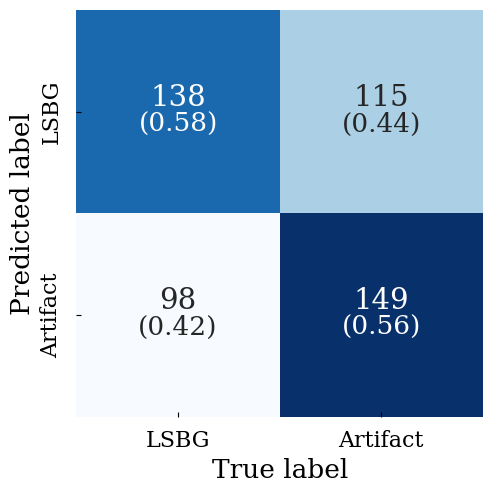

In [ ]:
class_names = ['LSBG','Artifact']
plot_confusion_matrix(y_lab[:n], y_pred_LSBG, rot=None, l_size=16, ax_size = 19, size=5.0, svname='LSBG_vs_Artifact_LLaVa', class_names=class_names)

In [ ]:
# Print some metrics
print("Overall accuracy:",accuracy_score(y_lab[:n], y_pred_LSBG))
print("Precision:", precision_score(y_lab[:n],y_pred_LSBG))
print("Recall:", recall_score(y_lab[:n],y_pred_LSBG))

Overall accuracy: 0.574
Precision: 0.6032388663967612
Recall: 0.5643939393939394


## **Part II) Galaxy Morphology**

In [ ]:
prompt_template_morphology = """
You are tasked to classify images depicting galaxies, into four morphological categories:

Category 0: smooth and round galaxy. Should not have signs of spires.

Category 1: smooth and cigar-shaped galaxy, looks like being seen edge on. This should not have signs of spires of a spiral galaxy

Category 2: edge-on-disk/spiral galaxy. This disk galaxy should have signs of spires, as seen from an edge-on perspective

Category 3:  unbarred spiral galaxy. Has signs of a disk and/or spires

Note that categories 1 and 2 tend to be very similar to each other.
To categorize them, ask yourself the following question: Is this galaxy very smooth, maybe with a small bulge? Then it
belongs to category 1. Does it have irregularities/signs of structure? Then it belongs to category 2.

To which category does the image belong?
"""

# Now format it in a way that can be passed into
prompt_morphology = "USER: <image>\n"+prompt_template_morphology+"\nASSISTANT:"

- Run predictions in a loop

In [ ]:
n = 500

y_pred_morphology = np.zeros(n)

for i in range(n):
  # Save image in directory; PNG format
  plt.imsave('Example_Image.png', images_ra[i])
  # encode it
  encoded = encode_image('Example_Image.png')

  # ouput of the pipeline
  outputs = pipe_LLaVa(encoded, prompt=prompt_morphology, generate_kwargs={"max_new_tokens": 200})
  # generated text of the pipeline
  generated_text = outputs[0]["generated_text"]


  # get structured output - pass the raw text generated from LLaVa
  y_pred_morphology[i] = int(gpt_4o_structured(generated_text.split("ASSISTANT:")[-1]))



  if (i%10==0):
    sleep(3)
    if (i%50==0):
      print(i)

0
50
100
150
200
250
300
350
400
450


In [ ]:
# Save the predictions array, so we don't have to run the predictions every time
np.save('preds_morphology_LLaVa',y_pred_morphology)

# We can load the array if we want to here
#y_pred_morphology = np.load('preds_morphology_LLaVa.npy')

- Make a plot of the **confusion matrix**

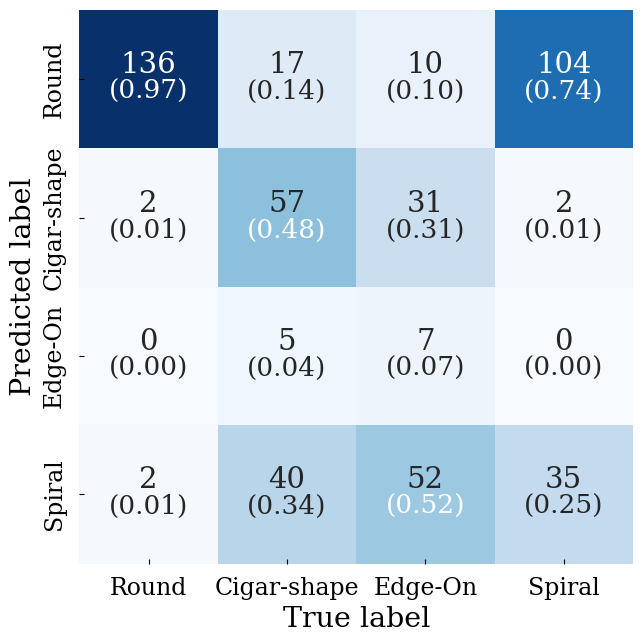

In [ ]:
class_names = ['Round', 'Cigar-shape', 'Edge-On','Spiral']
plot_confusion_matrix(labels_np[:n], y_pred_morphology, rot=None,l_size=17, ax_size=20.5, size=6.5,svname='morphology_LLaVa', class_names=class_names)

In [ ]:
# Print metrics
print("Overall accuracy:",accuracy_score(labels_np[:n], y_pred_morphology))

Overall accuracy: 0.47
